In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("../dados-ru/Tabela_1min.csv",
                   parse_dates=['Datetime']
                   # index_col='data' # Quando o cabeçalho for corrigido
                  )
data = data.rename(columns={'Datetime':'data',
                            'Num_pessoas':'num_pessoas',
                            'Refeição':'refeicao',
                            'Carne':'proteina'
                           })

data = data.set_index("data")
data.head()

,num_pessoas,refeicao,proteina
data,,,
2019-03-01 06:46:00,5,Café da Manhã,NaN
2019-03-01 06:47:00,10,Café da Manhã,NaN
2019-03-01 06:49:00,4,Café da Manhã,NaN
2019-03-01 06:50:00,5,Café da Manhã,NaN
2019-03-01 06:51:00,3,Café da Manhã,NaN


In [18]:
data = data[data.refeicao == 'Almoço'].resample("1D").aggregate({
    'num_pessoas': sum,
    'refeicao': max,
    'proteina': max
}).dropna()

In [23]:
data.head()

,num_pessoas,refeicao,proteina
data,,,
2019-03-01,3223,Almoço,Frango assado
2019-03-07,3451,Almoço,Bife à gaucho
2019-03-08,3494,Almoço,Frango mostarda
2019-03-11,3914,Almoço,Churrasco
2019-03-12,4114,Almoço,Frango ao sugo


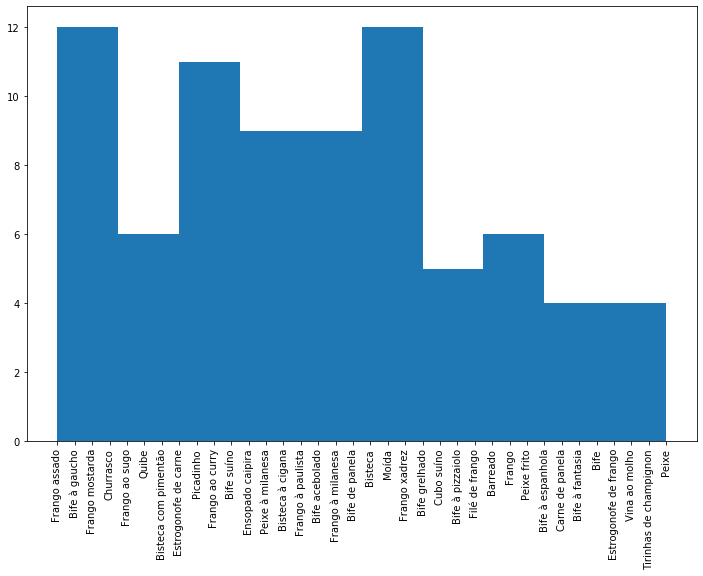

In [36]:
plt.figure(figsize=(12,8))
plt.hist(data.proteina)
plt.xticks(rotation='vertical')
plt.show()

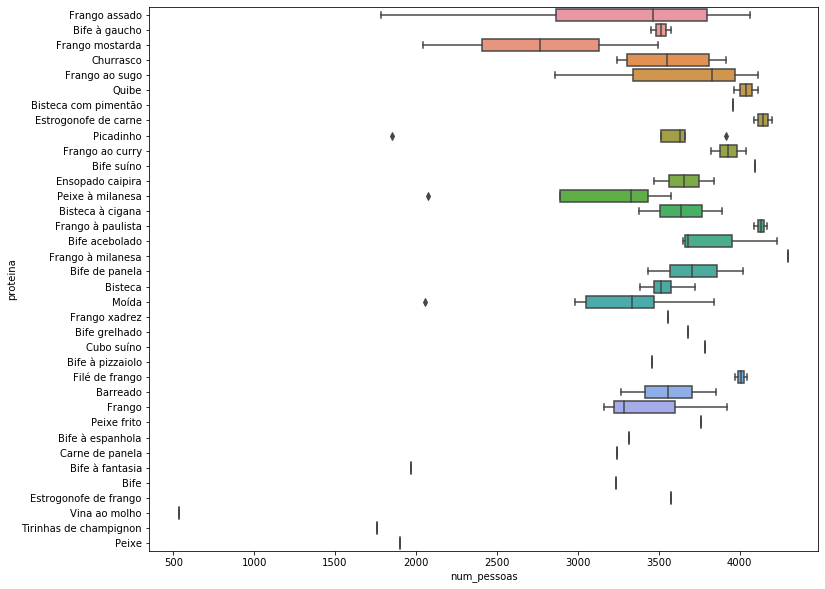

In [57]:
plt.figure(figsize=(12,10))
sns.boxplot(data=data, x='num_pessoas', y='proteina')

In [69]:
from sklearn.cluster import AgglomerativeClustering

X = pd.get_dummies(data.iloc[:,0:])

clust = AgglomerativeClustering()
clust.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2,
                        pooling_func='deprecated')

In [73]:
clust.n_clusters

2

In [75]:
data[clust.labels_ == 0]

,num_pessoas,refeicao,proteina
data,,,
2019-03-01,3223,Almoço,Frango assado
2019-03-07,3451,Almoço,Bife à gaucho
2019-03-08,3494,Almoço,Frango mostarda
2019-03-11,3914,Almoço,Churrasco
2019-03-12,4114,Almoço,Frango ao sugo
...,...,...,...
2019-06-12,3244,Almoço,Carne de panela
2019-06-13,3436,Almoço,Peixe à milanesa
2019-06-17,3117,Almoço,Moída


In [244]:
from fuzzywuzzy import fuzz, process

def categoriza_proteinas(proteina):
    classes = ["frango assado", "frango cozido", "frango frito", "peixe cozido", "peixe frito", "bife", "carne moída",
               "carne assada", "carne cozida", "bisteca", "quibe", "barreado", "vina", "suíno",
               "frango a milanesa", "estrogonofe de carne", "estrogonofe de frango",
               "tirinhas de champignon", "filé de frango"
              ]
    palavras_chaves = {"churrasco": "carne assada",
                       "frango mostarda": "frango assado",
                       "frango curry": "frango assado",
                       "peixe milanesa": "peixe frito",
                       "picadinho": "carne cozida",
                       "ensopado caipira": "carne cozida",
                       "frango ao sugo": "frango cozido",
                       "carne de panela": "carne cozida",
                       "frango xadrez": "frango cozido"
                      }
    
    proteina = proteina.lower()
    if proteina in classes:
        return proteina, 100
    for classe in classes:
        if classe in proteina:
            return classe, 100
    for chave in palavras_chaves:
        valor = palavras_chaves[chave]
        if fuzz.ratio(chave, proteina) >= 90:
            return valor, fuzz.ratio(chave, proteina)
    
    melhor = process.extractOne(proteina, classes)
    if melhor[1] >= 65:
        return melhor
    melhor = process.extractOne(proteina, palavras_chaves.keys())
    if melhor[1] >= 65:
        return palavras_chaves[melhor[0]], melhor[1]
    
    return np.nan, 0

In [245]:
data['cls_prot'] = data.proteina.apply(categoriza_proteinas)
data['cls_prot_score'] = [x[1] for x in data['cls_prot']]
data['cls_prot'] = [x[0] for x in data['cls_prot']]
data

,num_pessoas,refeicao,proteina,cls_prot,cls_prot_score
data,,,,,
2019-03-01,3223,Almoço,Frango assado,frango assado,100
2019-03-07,3451,Almoço,Bife à gaucho,bife,100
2019-03-08,3494,Almoço,Frango mostarda,frango assado,100
2019-03-11,3914,Almoço,Churrasco,carne assada,100
2019-03-12,4114,Almoço,Frango ao sugo,frango cozido,100
...,...,...,...,...,...
2019-06-24,1851,Almoço,Picadinho,carne cozida,100
2019-06-25,2044,Almoço,Frango mostarda,frango assado,100
2019-06-26,1760,Almoço,Tirinhas de champignon,tirinhas de champignon,100


In [246]:
data.sort_values(by='cls_prot_score').head(10)

,num_pessoas,refeicao,proteina,cls_prot,cls_prot_score
data,,,,,
2019-04-09,4092,Almoço,Frango à paulista,frango assado,69
2019-03-26,4167,Almoço,Frango à paulista,frango assado,69
2019-06-28,1902,Almoço,Peixe,peixe cozido,90
2019-05-07,3924,Almoço,Frango,frango assado,90
2019-05-24,2985,Almoço,Moída,carne moída,90
2019-05-03,3391,Almoço,Moída,carne moída,90
2019-06-27,2053,Almoço,Moída,carne moída,90
2019-06-17,3117,Almoço,Moída,carne moída,90
2019-05-08,3553,Almoço,Moída,carne moída,90


In [247]:
df = data[data['cls_prot'].isnull()]
df.shape, df

((0, 5), Empty DataFrame
 Columns: [num_pessoas, refeicao, proteina, cls_prot, cls_prot_score]
 Index: [])

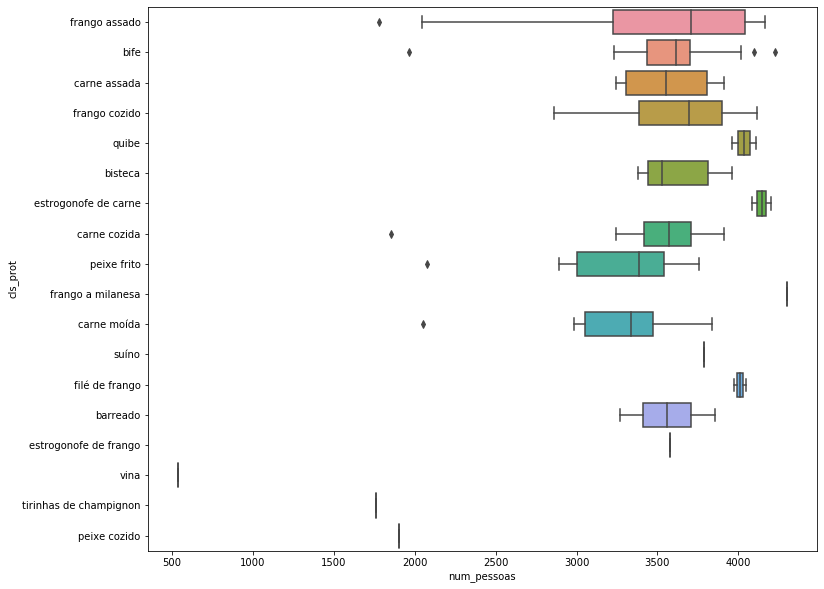

In [250]:
plt.figure(figsize=(12,10))
sns.boxplot(data=data, x='num_pessoas', y='cls_prot')